## Going through all metrics to check whether significant (not 0) --
Created: September 6, 2018
Last worked on: September 14, 2018

In [1]:
#ONLY run when there is garbage data in files
## Prepping files - Removing random data 
import re
import csv
import os
import glob

for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
    cmd = "tr -cd \'\\11\\12\\15\\40-\\176\' < "+filen_ +" >"+ filen_+".temp"
    cmd2 = "mv " + filen_ + ".temp " + filen_
    os.system( cmd )
    os.system(cmd2)
#string = open("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/gaussian_N1024.csv").read()
#new_str = re.sub('[^a-zA-Z0-9\n\.]', ' ', string)
#open('b.txt', 'w').write(new_str)

#txt_file = r"b.txt"
#csv_file = r"mycsv.csv"
#in_txt = csv.reader(open(txt_file,"r"),delimiter =' ')
#out_csv = csv.writer(open(csv_file, 'w'))
#out_csv.writerows(in_txt)

## RUN 3 below only if attaching stream data

In [37]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:

import os
import sys
import pandas as pd
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from all_apps import sweep_an
#stream_data = {}
combined_stream = sweep_an.all_st()
#print(stream_data)


#df.plot(x='size', y='dram_read_transactions', kind='scatter')

In [39]:
#print(combined_stream)
c_stream = {k:v for k,v in combined_stream.items() if 'set_array' not in k}
combined_stream = c_stream

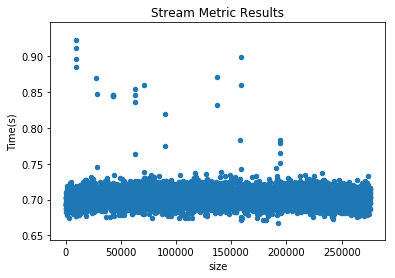

In [40]:
df_s = pd.DataFrame.from_dict(combined_stream,orient="index")
df_s.plot(x='size', y='Time(s)', kind='scatter', title='Stream Metric Results')
#df_s.plot(x='size', y='dram_read_transactions', kind='scatter',title='Stream Metric Results')
#df_s.plot(x='size', y='l2_read_transactions', kind='scatter', title='Stream Metric Results')
#df_s.plot(x='l2_read_transactions', y='Time(s)', kind='scatter', title='Stream Metric Results')

#print (df_s.head())

In [41]:
df_s['size'][0:5]

stream_100096_STREAM_Add      100096
stream_100096_STREAM_Copy     100096
stream_100096_STREAM_Scale    100096
stream_100096_STREAM_Triad    100096
stream_100224_STREAM_Add      100224
Name: size, dtype: int64

## Going through all single runs

In [443]:
#Going through metrics
import numbers
import glob
import os
import csv

if True:
    combined_data_ = {}

metric_targets = []
all_sig_metrics = []
bench_targets = [ "gaussian" ,"gemm", "stream" ]
for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/mixed_results/*.csv"):
#for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
    filen = os.path.basename(filen_)
    #print (filen)
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    #size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    #if not (bench_name in bench_targets): continue
    
    key_root = bench_name
    #print(key_root)
    levels = ["Idle", "Low","High", "Max"]
    bw_units = ["GB", "MB", "KB" ,"0B"]
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        #print (file_handle)
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        #print(filen_)
        for line_split in fdata:
            #print (line_split)
            lsplt = (len(line_split) > 0)
      
            if data_found:
                #print("data found")
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    #mname_index = index_lookup['Metric Name']
                    #metric_name = line_split[ mname_index ]
                    #if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0
                    metric_name = line_split[index_lookup['Metric Name']]
                    #print (line_split[target_index].isdecimal())
                    if line_split[target_index].isdecimal():
                        if line_split[target_index]!= '0':
                            #print(line_split[target_index])
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index ])
                        
                        # Labeled with percentage
                    elif "%" == line_split[target_index][-1]:
                        #print ("percentage loop")
                        all_sig_metrics.append(metric_name)
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif line_split[ target_index ][-4:-2] in bw_units:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        all_sig_metrics.append(metric_name)
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        elif units == "0B":  mfact = 1
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # idle, low, max
                    elif line_split[ target_index ][-1] == ")":
                        #print ("low")
                        all_sig_metrics.append(metric_name)
                        value = int(line_split[ target_index].split('(')[1].split(")")[0])
                        
                    # otherwise, float
                    #elif not(float(line_split[ target_index ]).is_integer()):
                    else:
                        #print(line_split[ target_index ].split('(')[0])
                        #print("in float")
                        #print(line_split[ target_index ].split('(')[0])
                        value = float(line_split[ target_index ])
                    
                    
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data_): 
                        combined_data_ [ key ] = {}
                        #combined_data_ [ key ][ 'size' ] = int( size_str )
                        
                    # Store value for the metric being read right now
                    combined_data_ [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                #print(index_lookup)
#print(combined_data_['huffman_vlc_encode_kernel_sm64huff'])


## Comparing metrics of different kernels - returns when values are different

In [118]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import os
import sys
import pandas as pd
%matplotlib inline


In [120]:
"""def compare_metrics(dict1,dict2,x):
    compared ={}
    #dict1 = combined_data_['hotspot_calculate_temp']
    #dict2 = combined_data_['huffman_vlc_encode_kernel_sm64huff']
    if x:
        diffkeys = [k for k in dict1 if dict1[k] != dict2[k]]
    else:
        diffkeys = [k for k in dict1 if dict1[k] == dict2[k]]
    for k in diffkeys:
        compared[k] =  dict1[k], dict2[k],abs(dict1[k]-dict2[k])

    return (compared)"""

In [244]:
"""def compare_all(large_dict,x):
    dif = {}
    for k,v in large_dict.items():
        for k2,v2 in large_dict.items():
            if k != k2:
                dict_compared = str(k) + "." + str(k2)
                dif[dict_compared] = compare_metrics(large_dict[k],large_dict[k2],x)
    return(dif)"""

In [311]:
"""diff_values = compare_all(use_dic,True)
same_values = compare_all(use_dic,False)"""

In [312]:
#print(diff_values)

In [313]:
"""top_values = [0]
print (min(top_values))
if min(top_values) < 4:
    if len(top_values) == 10:
        top_values.remove(min(top_values))
    top_values.append(4)
print (top_values)"""

0
[0, 4]


In [314]:
"""#from collections import defaultdict

top_dic = []
for k,v in diff_values.items():
    for k2,v2 in v.items():
        if (v2[-1]) > 391601:
            #print (k2, v2, k)
            if min(top_values) < v2[-1]:
                if len(top_values) == 10:
                    top_values.remove(min(top_values))
                    #top_dic.remove(min(top_dic))
                top_values.append(v2[-1])
            #top_dic.append((k,k2,v2[-1]))
            top_dic.append((k,v2[0],k2,v2[1],v2[-1]))
print(sorted(top_values))
#print(top_dic)
list_sorted = (sorted(top_dic, key=lambda tup:tup[2],reverse=True))"""

[941141151186.944, 941141151186.944, 949100799328.256, 949100799328.256, 965064119025.664, 965064119025.664, 1131346999115.776, 1131346999115.776, 1269474221096.96, 1269474221096.96]


In [315]:
### Are metrics with large differences in values among different kernels in apps similar to the metrics that are 
### used in predicting performance? What does it mean if they aren't? What do the metrics tell us about the applications? 
### Are apps with similar metrics more closely related?

In [318]:
"""top10 = list_sorted[:30]
#print(top10)
#for c in top10:
   # print(c[0].split('.')[0])"""

In [1]:
%reload_ext autoreload
%autoreload 2
from __future__ import absolute_import

In [5]:

import os
import sys
import pandas as pd
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from all_apps import compare_metrics



In [6]:
top_kernels_different = compare_metrics.sort_all(True,30000)
top_kernels_similar = compare_metrics.sort_all(False,20)

In [7]:
def metric_analysis(list_sorted,size):
    top10 = list_sorted[:size]
    for c in top10:
        print("First Kernel: %s, Metric: %s, Metric Value Dif: %5.5f, Metric Value: %5.5f" % (c[0].split('.')[0],c[2],c[4], c[1]))
        print("Second Kernel: %s, Metric: %s, Metric Value Dif: %5.5f, Metric Value: %5.5f" % (c[0].split('.')[1],c[2], c[4],c[3]))
        print("\n")

In [8]:
#print(top_kernels[:5])
for k in top_kernels_different[:20]:
    print (k)
with open ("stream_gemm_metric.csv", 'w') as f:
    f.write('\n'.join('{}, {}, {}, {}, {}'.format(x[0],x[1],x[2],x[3],x[4]) for x in top_kernels_different[:20]))
       

('gemm_sgemm_128x128x8_NN_vec.stream_set_array', 4321904839424, 'flop_count_sp', 0, 4321904839424)
('gemm_sgemm_128x128x8_NN_vec.stream_STREAM_Copy', 4321904839424, 'flop_count_sp', 0, 4321904839424)
('stream_set_array.gemm_sgemm_128x128x8_NN_vec', 0, 'flop_count_sp', 4321904839424, 4321904839424)
('stream_STREAM_Copy.gemm_sgemm_128x128x8_NN_vec', 0, 'flop_count_sp', 4321904839424, 4321904839424)
('gemm_sgemm_128x128x8_NN_vec.stream_STREAM_Scale', 4321904839424, 'flop_count_sp', 189952, 4321904649472)
('gemm_sgemm_128x128x8_NN_vec.stream_STREAM_Add', 4321904839424, 'flop_count_sp', 189952, 4321904649472)
('stream_STREAM_Scale.gemm_sgemm_128x128x8_NN_vec', 189952, 'flop_count_sp', 4321904839424, 4321904649472)
('stream_STREAM_Add.gemm_sgemm_128x128x8_NN_vec', 189952, 'flop_count_sp', 4321904839424, 4321904649472)
('gemm_sgemm_128x128x8_NN_vec.stream_STREAM_Triad', 4321904839424, 'flop_count_sp', 379904, 4321904459520)
('stream_STREAM_Triad.gemm_sgemm_128x128x8_NN_vec', 379904, 'flop_cou

In [63]:
import glob
import csv
metric_gaus = []
metric_gemm = []
all =[]
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/metric_comparison/*.csv"):
    with open(file,'r') as f:
        data = csv.reader(f)
        for line_split in data:
            #print (line_split)
            """if 'stream' in line_split[0] and 'gauss' in line_split[0]:
                metric_gaus.append(([line_split[2],line_split[4]]))
            if 'stream' in line_split[0] and 'gemm' in line_split[0]:
                metric_gemm.append(([line_split[2],line_split[4]]))"""
            if 'stream' in line_split[0]:
                if 'gemm' in line_split[0]:
                    all.append((['gemm',line_split[2],line_split[4]]))
                elif 'gauss' in line_split[0]:
                    all.append((['gauss',line_split[2],line_split[4]]))
                else:
                    print(os.path.basename(file), line_split[0])
                    all.append((['stream',line_split[2],line_split[4]]))
#print (metric_gaus)
#print(metric_gemm)
#print(all)

stream_gauss_metric.csv stream_set_array.stream_STREAM_Triad
stream_gauss_metric.csv stream_STREAM_Triad.stream_set_array
stream_gauss_metric.csv stream_set_array.stream_STREAM_Add
stream_gauss_metric.csv stream_STREAM_Add.stream_set_array
stream_gauss_metric.csv stream_set_array.stream_STREAM_Copy
stream_gauss_metric.csv stream_STREAM_Copy.stream_set_array
stream_gauss_metric.csv stream_set_array.stream_STREAM_Scale
stream_gauss_metric.csv stream_STREAM_Scale.stream_set_array
stream_gauss_metric.csv stream_set_array.stream_STREAM_Triad
stream_gauss_metric.csv stream_STREAM_Triad.stream_set_array
stream_gauss_metric.csv stream_set_array.stream_STREAM_Add
stream_gauss_metric.csv stream_STREAM_Add.stream_set_array


In [59]:
from IPython.display import HTML, display
import tabulate
import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

dict_all = {}
for i in all:
    if i[1] in dict_all:
        dict_all[i[1]] += 1
    else:
        dict_all[i[1]] = 1
v = dict_all.values()
print (list(v))
#print("Metric comparisons between Stream kernels and Gaussian and Gemm applications")
#display(HTML(tabulate.tabulate(all, tablefmt='html')))

[16, 4, 10, 6]


In [94]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(list(all), tablefmt='html')))

stream,gld_throughput,5.23463e+11
stream,gld_throughput,5.23463e+11
stream,gld_throughput,5.22833e+11
stream,gld_throughput,5.22833e+11
gauss,gld_throughput,5.19374e+11
gauss,gld_throughput,5.19374e+11
gauss,gld_throughput,5.18744e+11
gauss,gld_throughput,5.18744e+11
gauss,gld_throughput,4.12993e+11
gauss,gld_throughput,4.12993e+11
gauss,gld_throughput,4.12363e+11


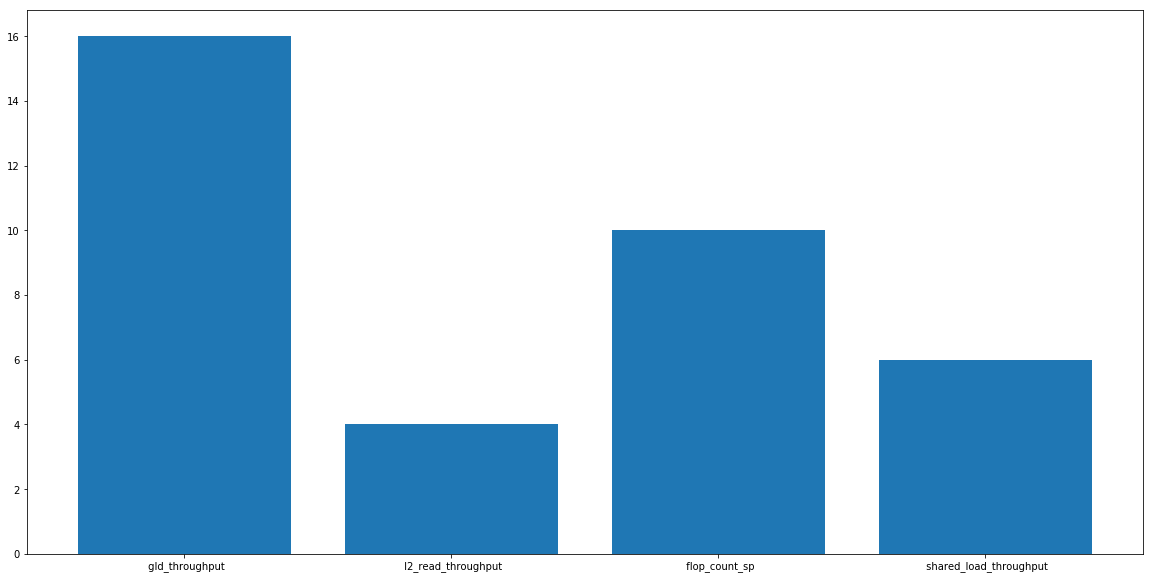

In [91]:
import matplotlib.pyplot as plt
#data_pd = pd.DataFrame(list(dict_all.items()))
plt.figure(figsize=(20,10))
plt.bar(range(len(dict_all)), list(dict_all.values()), align='center')
plt.xticks(range(len(dict_all)), list(dict_all.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()
#myplot = data_pd.plot(kind='bar')

In [448]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data_)
print ((df))

#df.plot(x='inst_per_warp', y='dram_read_transactions', kind='scatter', title="Gauss & Gemm Metric Results" )
#df.plot(x='inst_per_warp', y='l2_read_transactions', kind='scatter', title="Gauss & Gemm Metric Results")

                                       gemm_sgemm_128x128x8_NN_vec  \
achieved_occupancy                                    2.497920e-01   
atomic_transactions                                   0.000000e+00   
atomic_transactions_per_request                       0.000000e+00   
branch_efficiency                                     1.000000e+00   
cf_executed                                           1.332659e+08   
cf_fu_utilization                                     1.000000e+00   
cf_issued                                             1.332659e+08   
double_precision_fu_utilization                       0.000000e+00   
dram_read_throughput                                  1.670109e+11   
dram_read_transactions                                2.471221e+09   
dram_utilization                                      3.000000e+00   
dram_write_throughput                                 1.414998e+09   
dram_write_transactions                               2.093748e+07   
eligible_warps_per_c

In [449]:
executable = "gaussian"
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_time_timing/*.csv"):
    #nf = "gaussian_N128.csv"
    nf = os.path.basename(file)
    filesplt = os.path.basename(nf).split(".")[0].split('N')[1]
    filename = executable + "_" + filesplt
    #print(filename)
    for key, value in combined_data_.items():
        #print(key)
        if filename in key:
            with open(file) as results:
                for l in results:
                    if "Time for CUDA kernel 1" in l:
                        #print("in kern")
                        combined_data_[key]["Time(s)"] = float(l.split(":")[1].split()[0])
                
#print(combined_data_)

In [450]:
#gemm_N128.csv
executable = "gemm_"
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_timing/*.csv"):
    #print (file)
    filesplt = os.path.basename(file).split(".")[0].split('N')[1]
    filen = executable + filesplt +"_sge"
    #print(filen)
    for key, value in combined_data_.items():      
        if filen in key:
            with open(file) as results:
                for l in results:
                    if "average" in l:
                        combined_data_[key]["Time(s)"] = float(l.split(":")[2].split()[0])
#print(combined_data_)

stream_100096_STREAM_Add      0.689086
stream_100096_STREAM_Copy     0.699040
stream_100096_STREAM_Scale    0.708291
Name: Time(s), dtype: float64


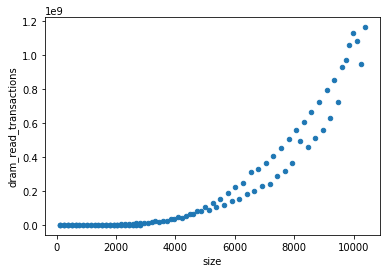

In [46]:
#Simple analysis of data
import pandas as pd
%matplotlib inline
#stream_data
df = pd.DataFrame.from_dict(combined_data_,orient="index")
#df = pd.DataFrame.from_dict(stream_data,orient="index")

df = df.dropna()
df_s = pd.DataFrame.from_dict(combined_stream,orient="index")
#df = pd.DataFrame.from_dict(stream_data,orient="index")

df_s = df_s.dropna()
print(df_s['Time(s)'][0:3])

#print (df.head())

df.plot(x='size', y='dram_read_transactions', kind='scatter')
#df.plot(x='dram_read_transactions', y='Time(s)', kind='scatter')
#df.plot(x='inst_per_warp', y='Time(s)', kind='scatter')
#df.plot(x='size', y='Time(s)', kind='scatter')

## Normalizing all data


In [47]:
"""column_names = list(df.columns.values)
metric_max = {}
count =0
for columns in df:
     metric_max[column_names[count]]= max(df[columns])
     count +=1"""
df_norm = (df-df.mean())/(df.std())
#df_norm = df_norm.dropna(axis='columns')
df_s_norm = (df_s-df_s.mean())/(df_s.std())
#df_s_norm = df_s_norm.dropna(axis='columns')
#print (df_norm['local_load_transactions_per_request'])

In [48]:
print(df_s_norm['Time(s)'][0:3])

stream_100096_STREAM_Add     -1.200821
stream_100096_STREAM_Copy    -0.384841
stream_100096_STREAM_Scale    0.373522
Name: Time(s), dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1509305e10>]],
      dtype=object)

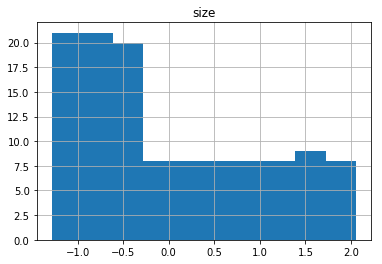

In [49]:
df_norm.hist(column='size')

# Further analysis of data - Random forest model, correlation graph, prediction graph

size                                    -0.045517
inst_per_warp                           -0.127429
branch_efficiency                             NaN
warp_execution_efficiency                     NaN
warp_nonpred_execution_efficiency       -0.126700
inst_replay_overhead                     0.020343
shared_load_transactions_per_request          NaN
shared_store_transactions_per_request         NaN
local_load_transactions_per_request           NaN
local_store_transactions_per_request          NaN
gld_transactions_per_request                  NaN
gst_transactions_per_request                  NaN
shared_store_transactions                     NaN
shared_load_transactions                      NaN
local_load_transactions                       NaN
local_store_transactions                      NaN
gld_transactions                        -0.097145
gst_transactions                        -0.045517
sysmem_read_transactions                      NaN
sysmem_write_transactions                     NaN


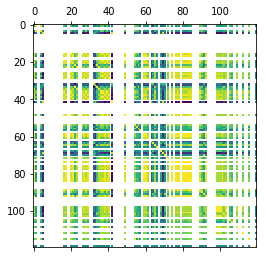

In [50]:
import matplotlib.pyplot as plt
#plt.matshow(df_norm.corr())
df_norm.dropna(how='any')
df_s_norm.dropna(how='any')
#print(df_s_norm.head())

import matplotlib.pyplot as plt
plt.matshow(df_s_norm.corr())
print(df_s_norm.corr()["Time(s)"])

In [51]:
"""import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import random
corrmat = df_norm.corr()
k = 20
cols = corrmat.nlargest(k, "Time(s)")["Time(s)"].index
cm = np.corrcoef(df_norm[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.rcParams['figure.figsize'] = [20, 40]
plt.show()"""

'import numpy as np\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfrom numpy.random import random\ncorrmat = df_norm.corr()\nk = 20\ncols = corrmat.nlargest(k, "Time(s)")["Time(s)"].index\ncm = np.corrcoef(df_norm[cols].values.T)\nsns.set(font_scale=1.25)\nhm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=\'.2f\', annot_kws={\'size\': 10}, yticklabels=cols.values, xticklabels=cols.values)\nplt.rcParams[\'figure.figsize\'] = [20, 40]\nplt.show()'

# Random Forest Model

### Cleaning up data, converting to dictionary to dataframe, running RF grid search 

In [52]:
import pandas as  pd
import numpy  as  np
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
import scipy as sp
import pickle as pkl
%matplotlib inline

In [53]:
#df_norm = df_norm.dropna(subset=['Time(s)'])
df_norm = df_norm.dropna(subset=['Time(s)'])

X  =  df_norm[['inst_per_warp','size','inst_replay_overhead','flop_sp_efficiency']]
y = df_norm['Time(s)']
print ("X size:", X.shape)
print ('y size:', y.shape)
df_s_norm = df_s_norm.dropna(subset=['Time(s)'])
X_s = df_s_norm[['inst_per_warp','size','inst_replay_overhead','flop_sp_efficiency']]
y_s = df_s_norm['Time(s)']
print ("X Stream size:", X_s.shape)
print ('y Stream size:', y_s.shape)
#print(df_norm.head())

X size: (119, 4)
y size: (119,)
X Stream size: (8616, 4)
y Stream size: (8616,)


In [54]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(1,4)),
                     scoring='neg_mean_squared_error',
                    cv=10)

In [55]:
model.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(1, 4)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

## Scoring

In [56]:
from sklearn.model_selection import cross_val_score
#cross_val_score(model, X, y, scoring='neg_median_absolute_error') 
cross_val_score(model, X, y, scoring='neg_mean_squared_error') 


array([-0.03872133, -0.10599177, -0.6758937 ])

Text(0,0.5,'RMSD')

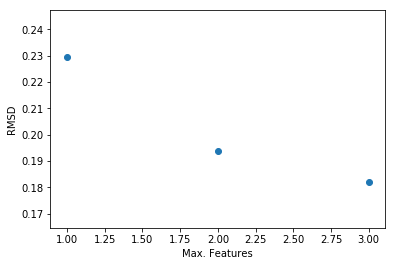

In [57]:
fig, ax = plt.subplots()
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSD')

In [58]:
model = model.best_estimator_


In [59]:
list(zip(X.columns,model.feature_importances_))

[('inst_per_warp', 0.4703462877864571),
 ('size', 0.5128281844011725),
 ('inst_replay_overhead', 0.01413620912586609),
 ('flop_sp_efficiency', 0.002689318686504339)]

## Testing model with GEMM and Gaussian App


In [60]:
from sklearn.model_selection import train_test_split
all_y_test = np.zeros((0,))
all_y_pred = np.zeros((0,))
#given options and list of data, returns the indices of training and test sets 
for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
    # Split off the train and test set
    X_test, y_test = X.iloc[test_inds, :], y[test_inds]
    X_train, y_train = X.iloc[train_inds, :], y[train_inds]
    
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Append the results
    all_y_test = np.concatenate((all_y_test, y_test))
    #print (all_y_test)
    all_y_pred = np.concatenate((all_y_pred, y_pred))

In [61]:
print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')

R: 0.9994356902722722
MAE: 0.03026957089945948 s
RMSE: 0.04839965051964942 s


## Testing model using streaming data

In [62]:
all_ys_test = np.zeros((0,))
all_ys_pred = np.zeros((0,))
for train_s_inds, test_s_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X_s,y_s):
    #print (test_s_inds)
    # Split off the train and test set
    X_s_test, y_s_test = X_s.iloc[test_s_inds, :], y_s[test_s_inds]
    #print(X_s_test)
    #X_train, y_train = X_s.iloc[train_inds, :], y_s[train_inds]
    
    # Train the model
    y_s_pred = model.predict(X_s_test)
    
    # Append the results
    all_ys_test = np.concatenate((all_ys_test, y_s_test))
    #print (all_y_test)
    all_ys_pred = np.concatenate((all_ys_pred, y_s_pred))

In [63]:
print ("R:",  sp.stats.pearsonr(all_ys_test, all_ys_pred)[0])
print ("MAE:", np.abs(all_ys_test - all_ys_pred).mean(), 's')
print ("RMSE:", np.sqrt(np.power(all_ys_test - all_ys_pred, 2).mean()), 's')

R: -0.104552537811959
MAE: 0.793787691720527 s
RMSE: 1.1203057082085268 s


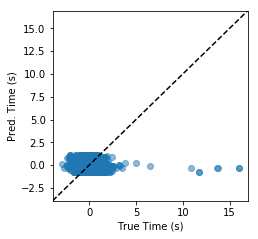

In [64]:
fig, ax = plt.subplots()

# Make the plot
ax.scatter(all_ys_test, all_ys_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True Time (s)')
ax.set_ylabel('Pred. Time (s)')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

# Trimming down features 

## Creating model with features with importance of >= 5

In [30]:
feature_importance = list(zip(X.columns,model.feature_importances_))
correlation = (df_s.corr()["Time(s)"])

In [31]:
#print(feature_importance)
print ((correlation))

size                                    -0.045517
inst_per_warp                           -0.127429
branch_efficiency                             NaN
warp_execution_efficiency                     NaN
warp_nonpred_execution_efficiency       -0.126700
inst_replay_overhead                     0.020343
shared_load_transactions_per_request          NaN
shared_store_transactions_per_request         NaN
local_load_transactions_per_request           NaN
local_store_transactions_per_request          NaN
gld_transactions_per_request                  NaN
gst_transactions_per_request                  NaN
shared_store_transactions                     NaN
shared_load_transactions                      NaN
local_load_transactions                       NaN
local_store_transactions                      NaN
gld_transactions                        -0.097145
gst_transactions                        -0.045517
sysmem_read_transactions                      NaN
sysmem_write_transactions                     NaN


## Creating feature list dependent on set threshold

In [32]:
# Change threshold
def feature_list(threshold):

    all_met = df.columns.values
    #print(combined_data_["metrics"])
    #print (correlation[-0.929979])
    needed_features = []
    for m in all_met:
        if correlation[m] >= threshold or correlation[m] <= (-1)*threshold:
            needed_features.append(m)
    needed_features.remove("Time(s)")
    return (needed_features)
 
    
 
   

In [33]:
import numpy as np
list_fea = {}
count = 0
for i in np.arange(.5,1,0.1):
    i = format(i,'.1f')
    key = "feature_" + str(i)
    #print (key)
    list_fea["feature_" + str(i)] = feature_list(float(i))
    print(len(list_fea["feature_" + str(i)]))
print("Number of features from (+-).5 to (+-).9 correlation values")

0
0
0
0
0
Number of features from (+-).5 to (+-).9 correlation values


In [34]:
feature_95 = feature_list(.95)
feature_97 = feature_list(.97)
print(feature_95)

[]


## Run model function - takes in list of features to use

In [35]:
import pandas as pd
%matplotlib inline

def run_model(cur_features,num_features):   
    df = pd.DataFrame.from_dict(combined_data_,orient="index")
    #display(df.head())
    df = df.dropna()
    X = df[cur_features]
    y = df['Time(s)']
    #df = df.dropna()

    #print (df)
    print ("X size:", X.shape)
    print ('y size:', y.shape)
    model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                         param_grid=dict(max_features=range(2,num_features)),
                         scoring='neg_mean_squared_error',
                        cv=10)
    model.fit(X,y)
    model.fit(X,y)
    all_y_test = np.zeros((0,))
    all_y_pred = np.zeros((0,))
    #given options and list of data, returns the indices of training and test sets 
    for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
        # Split off the train and test set
        X_test, y_test = X.iloc[test_inds, :], y[test_inds]
        X_train, y_train = X.iloc[train_inds, :], y[train_inds]

        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Append the results
        all_y_test = np.concatenate((all_y_test, y_test))
        #print (all_y_test)
        all_y_pred = np.concatenate((all_y_pred, y_pred))

    print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
    print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
    print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')

    fig, ax = plt.subplots()

    # Make the plot
    ax.scatter(all_y_test, all_y_pred, alpha=0.5)

    # Make it pretty
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())

    ax.set_xlabel('True Time (s)')
    ax.set_ylabel('Pred. Time (s)')

    fig.set_size_inches(3.5, 3.5)

    # Add in the goal line
    ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

## .5 Correlation Value

In [36]:
#print(list_fea["feature_0.5"])
run_model(list_fea["feature_0.5"],len(list_fea["feature_0.5"]))

X size: (119, 0)
y size: (119,)


ValueError: Parameter values for parameter (max_features) need to be a non-empty sequence.

## .6 Correlation Value

In [ ]:
run_model(list_fea["feature_0.6"],len(list_fea["feature_0.6"]))

## .7 Correlation Value

In [ ]:
run_model(list_fea["feature_0.7"],len(list_fea["feature_0.7"]))

## .8 Correlation Value

In [ ]:

run_model(list_fea["feature_0.8"],len(list_fea["feature_0.8"]))

## .9 Correlation Value

In [ ]:
#print(list_fea["feature_0.5"])
run_model(list_fea["feature_0.9"],len(list_fea["feature_0.9"]))

## .95 Correlation Value

In [ ]:
#len(feature_95)
run_model(feature_95,7)

## .97 Correlation Value

In [ ]:
run_model(feature_97,len(feature_97))

## Plotting learning curve 
### Both training and test score improve and remain high throughout sampling size

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Random Forst)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

"""title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)"""

plt.show()

In [ ]:
## Using this, what can we do with k-means (transfer learning or performance prediction)